## Standard Imports

In [ ]:
# standard imports
import tensorflow as tf            # tensorflow importing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D,Conv1DTranspose,Concatenate,Input, PReLU
from tensorflow.keras.layers import BatchNormalization, Dense, Flatten, LeakyReLU
import numpy as np                 # numpy package importing
import matplotlib.pyplot as plt    # matplotlib package importing
import IPython.display
import glob
from tqdm.notebook import tqdm     # a library used to visualize progress as a dynamic filling bar 
import librosa.display              # a python package used to do analysis on audio data and visualize it

## Loading the dataset

In [ ]:
!mkdir "CleanData"
!mkdir "NoisyData"

In [ ]:
!unzip "/content/drive/My Drive/ML works/SoC/clean_trainset_wav.zip" -d "CleanData"

Streaming output truncated to the last 5000 lines.
  inflating: CleanData/p267_421.wav  
  inflating: CleanData/p268_001.wav  
  inflating: CleanData/p268_002.wav  
  inflating: CleanData/p268_003.wav  
  inflating: CleanData/p268_004.wav  
  inflating: CleanData/p268_005.wav  
  inflating: CleanData/p268_006.wav  
  inflating: CleanData/p268_007.wav  
  inflating: CleanData/p268_009.wav  
  inflating: CleanData/p268_010.wav  
  inflating: CleanData/p268_011.wav  
  inflating: CleanData/p268_012.wav  
  inflating: CleanData/p268_013.wav  
  inflating: CleanData/p268_014.wav  
  inflating: CleanData/p268_015.wav  
  inflating: CleanData/p268_016.wav  
  inflating: CleanData/p268_017.wav  
  inflating: CleanData/p268_018.wav  
  inflating: CleanData/p268_019.wav  
  inflating: CleanData/p268_020.wav  
  inflating: CleanData/p268_021.wav  
  inflating: CleanData/p268_022.wav  
  inflating: CleanData/p268_024.wav  
  inflating: CleanData/p268_025.wav  
  inflating: CleanData/p268_026.wav  

In [ ]:
!unzip "/content/drive/My Drive/ML works/SoC/noisy_trainset_wav.zip" -d "NoisyData"

Streaming output truncated to the last 5000 lines.
  inflating: NoisyData/p267_421.wav  
  inflating: NoisyData/p268_001.wav  
  inflating: NoisyData/p268_002.wav  
  inflating: NoisyData/p268_003.wav  
  inflating: NoisyData/p268_004.wav  
  inflating: NoisyData/p268_005.wav  
  inflating: NoisyData/p268_006.wav  
  inflating: NoisyData/p268_007.wav  
  inflating: NoisyData/p268_009.wav  
  inflating: NoisyData/p268_010.wav  
  inflating: NoisyData/p268_011.wav  
  inflating: NoisyData/p268_012.wav  
  inflating: NoisyData/p268_013.wav  
  inflating: NoisyData/p268_014.wav  
  inflating: NoisyData/p268_015.wav  
  inflating: NoisyData/p268_016.wav  
  inflating: NoisyData/p268_017.wav  
  inflating: NoisyData/p268_018.wav  
  inflating: NoisyData/p268_019.wav  
  inflating: NoisyData/p268_020.wav  
  inflating: NoisyData/p268_021.wav  
  inflating: NoisyData/p268_022.wav  
  inflating: NoisyData/p268_024.wav  
  inflating: NoisyData/p268_025.wav  
  inflating: NoisyData/p268_026.wav  

In [ ]:
clean_sounds = glob.glob('/content/CleanData/*')
clean_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(clean_sounds[0]),desired_channels=1)
for i in tqdm(clean_sounds[1:]):
  so,_ = tf.audio.decode_wav(tf.io.read_file(i),desired_channels=1)
  clean_sounds_list = tf.concat((clean_sounds_list,so),0)

  0%|          | 0/11571 [00:00<?, ?it/s]

In [ ]:
noisy_sounds = glob.glob('/content/NoisyData/*')
noisy_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(noisy_sounds[0]),desired_channels=1)
for i in tqdm(noisy_sounds[1:]):
  so,_ = tf.audio.decode_wav(tf.io.read_file(i),desired_channels=1)
  noisy_sounds_list = tf.concat((noisy_sounds_list,so),0)

  0%|          | 0/11571 [00:00<?, ?it/s]

In [ ]:
print(len(clean_sounds_list),len(noisy_sounds_list))

540938091 540938091


In [ ]:
batching_size = 16384

clean_train,noisy_train = [],[]

for i in tqdm(range(0,clean_sounds_list.shape[0]-batching_size,batching_size)):
  clean_train.append(clean_sounds_list[i:i+batching_size])
  noisy_train.append(noisy_sounds_list[i:i+batching_size])

# clean_train_data = tf.stack(clean_train)
# noisy_train_data = tf.stack(noisy_train)

len(clean_train),len(noisy_train)

  0%|          | 0/33016 [00:00<?, ?it/s]

(33016, 33016)

In [ ]:
clean_train = tf.stack(clean_train)

In [ ]:
clean_sounds_list = []

In [ ]:
noisy_sounds_list = []

In [ ]:
noisy_train = tf.stack(noisy_train)

In [ ]:
clean_train.shape, noisy_train.shape

(TensorShape([33016, 16384, 1]), TensorShape([33016, 16384, 1]))

## Building the model

### Generator

- The model is built as described in the SEGAN paper which comprises of 22 1d convolution layers (both conv1D and conv1DTranspose) 
- Each conv1D layer is followed by a PReLU activtion layer

In [ ]:
inp = Input(shape=(16384,1))
# c1 = Conv1D(16,32,2,'same',activation='relu')(inp)
# c2 = Conv1D(32,32,2,'same',activation='relu')(c1)
# c3 = Conv1D(32,32,2,'same',activation='relu')(c2)
# c4 = Conv1D(64,32,2,'same',activation='relu')(c3)
# c5 = Conv1D(64,32,2,'same',activation='relu')(c4)
# c6 = Conv1D(128,32,2,'same',activation='relu')(c5)
# c7 = Conv1D(128,32,2,'same',activation='relu')(c6)
# c8 = Conv1D(256,32,2,'same',activation='relu')(c7)
# c9 = Conv1D(256,32,2,'same',activation='relu')(c8)
# c10 = Conv1D(512,32,2,'same',activation='relu')(c9)
# c11 = Conv1D(1024,32,2,'same',activation='relu')(c10)

# encoder stage

c1 = Conv1D(16,32,2,'same')(inp)
c1 = PReLU()(c1)

c2 = Conv1D(32,32,2,'same')(c1)
c2 = PReLU()(c2)

c3 = Conv1D(32,32,2,'same')(c2)
c3 = PReLU()(c3)

c4 = Conv1D(64,32,2,'same')(c3)
c4 = PReLU()(c4)

c5 = Conv1D(64,32,2,'same')(c4)
c5 = PReLU()(c5)

c6 = Conv1D(128,32,2,'same')(c5)
c6 = PReLU()(c6)

c7 = Conv1D(128,32,2,'same')(c6)
c7 = PReLU()(c7)

c8 = Conv1D(256,32,2,'same')(c7)
c8 = PReLU()(c8)

c9 = Conv1D(256,32,2,'same')(c8)
c9 = PReLU()(c9)

c10 = Conv1D(512,32,2,'same')(c9)
c10 = PReLU()(c10)

c11 = Conv1D(1024,32,2,'same')(c10)
c11 = PReLU()(c11)

# decoder stage

dc1 = Conv1DTranspose(1024,32,1,padding='same')(c11)
dc1 = PReLU()(dc1)
conc = Concatenate()([c11,dc1])

dc2 = Conv1DTranspose(512,32,2,padding='same')(conc)
dc2 = PReLU()(dc2)
conc = Concatenate()([c10,dc2])

dc3 = Conv1DTranspose(256,32,2,padding='same')(conc)
dc3 = PReLU()(dc3)
conc = Concatenate()([c9,dc3])

dc4 = Conv1DTranspose(256,32,2,padding='same')(conc)
dc4 = PReLU()(dc4)
conc = Concatenate()([c8,dc4])

dc5 = Conv1DTranspose(128,32,2,padding='same')(conc)
dc5 = PReLU()(dc5)
conc = Concatenate()([c7,dc5])

dc6 = Conv1DTranspose(128,32,2,padding='same')(conc)
dc6 = PReLU()(dc6)
conc = Concatenate()([c6,dc6])

dc7 = Conv1DTranspose(64,32,2,padding='same')(conc)
dc7 = PReLU()(dc7)
conc = Concatenate()([c5,dc7])

dc8 = Conv1DTranspose(64,32,2,padding='same')(conc)
dc8 = PReLU()(dc8)
conc = Concatenate()([c4,dc8])

dc9 = Conv1DTranspose(32,32,2,padding='same')(conc)
dc9 = PReLU()(dc9)
conc = Concatenate()([c3,dc9])

dc10 = Conv1DTranspose(32,32,2,padding='same')(conc)
dc10 = PReLU()(dc10)
conc = Concatenate()([c2,dc10])

dc11 = Conv1DTranspose(16,32,2,padding='same')(conc)
dc11 = PReLU()(dc11)
conc = Concatenate()([c1,dc11])

dc12 = Conv1DTranspose(1,32,2,padding='same')(conc)
# dc12 = PReLU()(dc12)
conc = Concatenate()([inp,dc12])

dc13 = Conv1DTranspose(1,32,1,padding='same',activation='linear')(conc)

generatormodel = tf.keras.models.Model(inp,dc13)

In [ ]:
generatormodel.summary()

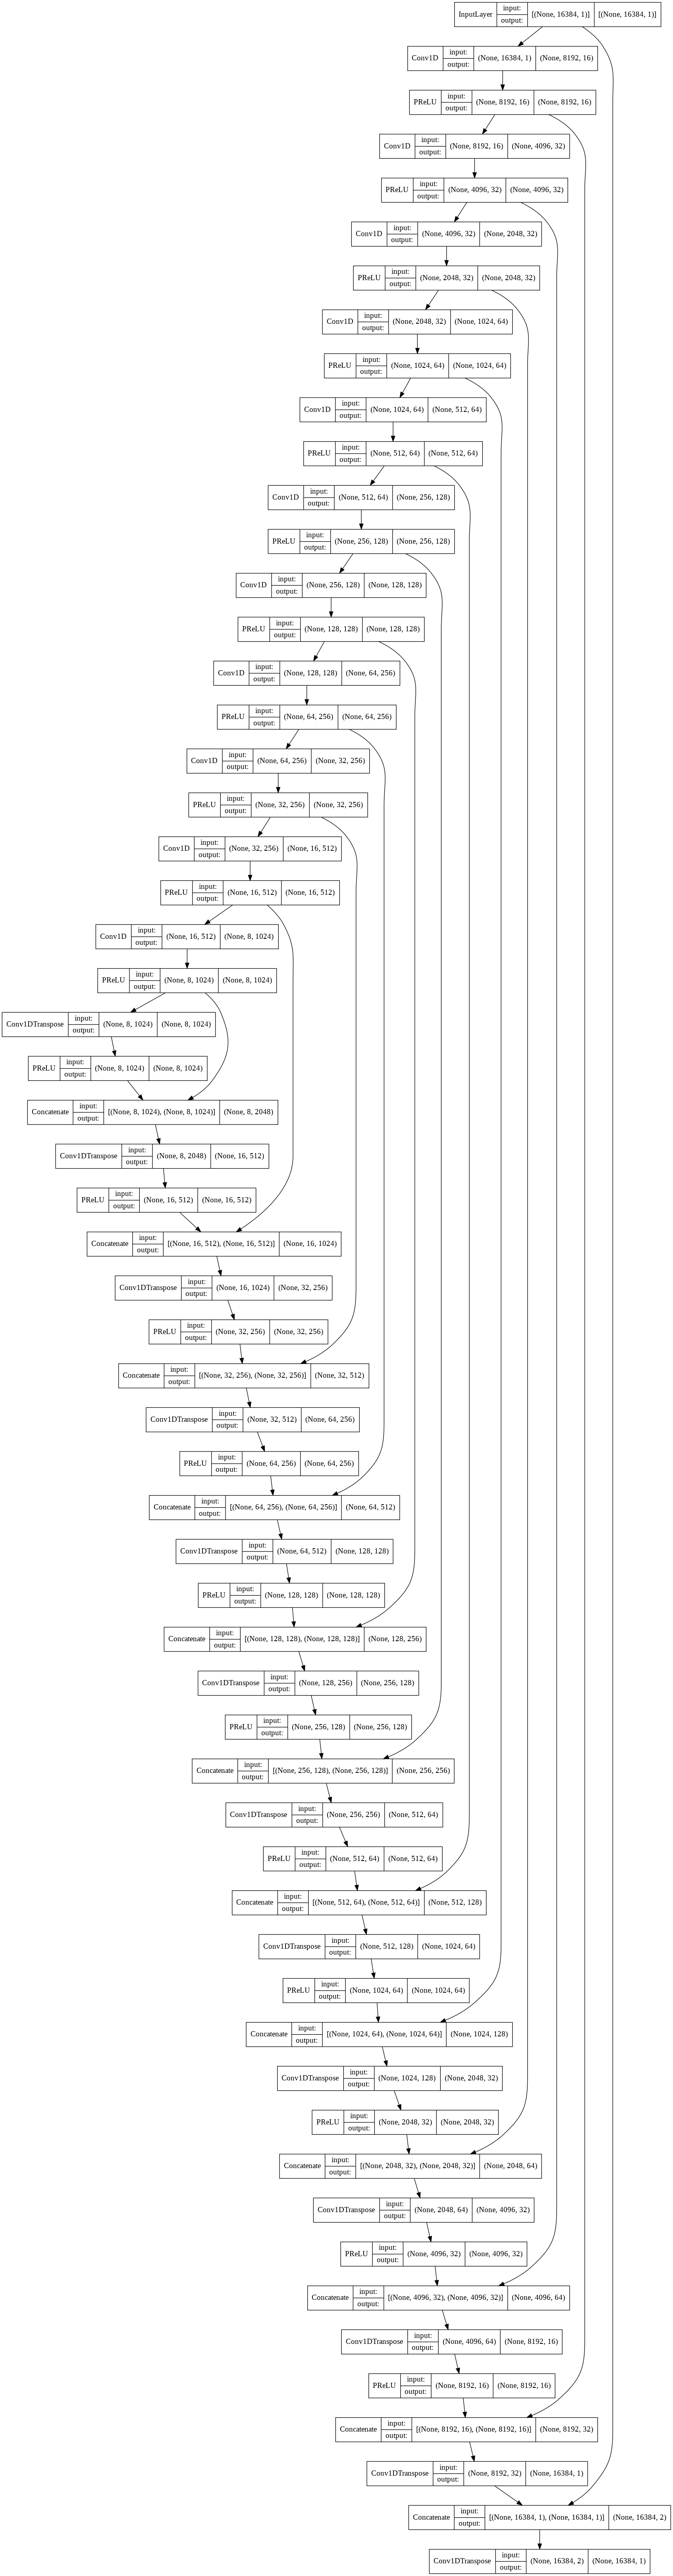

In [ ]:
tf.keras.utils.plot_model(generatormodel,show_shapes=True,show_layer_names=False)

## Discriminator

In [ ]:
# inp = Input(shape=(16384,2))
inp = (16384,2)
discriminatormodel = Sequential([
                  Conv1D(16,32,2,'same', input_shape = inp),
                  LeakyReLU(alpha=0.3),

                  Conv1D(32,32,2,'same'),
                  LeakyReLU(alpha=0.3),
                  
                  Conv1D(32,32,2,'same'),
                  LeakyReLU(alpha=0.3),
                  
                  Conv1D(64,32,2,'same'),
                  LeakyReLU(alpha=0.3),
                  
                  Conv1D(64,32,2,'same'),
                  LeakyReLU(alpha=0.3),
                  
                  Conv1D(128,32,2,'same'),
                  LeakyReLU(alpha=0.3),
                  
                  Conv1D(128,32,2,'same'),
                  LeakyReLU(alpha=0.3),
                  
                  Conv1D(256,32,2,'same'),
                  LeakyReLU(alpha=0.3),
                  
                  Conv1D(256,32,2,'same'),
                  LeakyReLU(alpha=0.3),
                  
                  Conv1D(512,32,2,'same'),
                  LeakyReLU(alpha=0.3),
                  
                  Conv1D(1024,32,2,'same'),
                  LeakyReLU(alpha=0.3),

                  Conv1D(1,32,1,'same'),
                  LeakyReLU(alpha=0.3),

                  Dense(1, activation=None),  
])
# c1 = Conv1D(16,32,2,'same', input_shape = inp)
# c1 = LeakyReLU(alpha=0.3)(c1)

# c2 = Conv1D(32,32,2,'same')(c1)
# c2 = LeakyReLU(alpha=0.3)(c2)

# c3 = Conv1D(32,32,2,'same')(c2)
# c3 = LeakyReLU(alpha=0.3)(c3)

# c4 = Conv1D(64,32,2,'same')(c3)
# c4 = LeakyReLU(alpha=0.3)(c4)

# c5 = Conv1D(64,32,2,'same')(c4)
# c5 = LeakyReLU(alpha=0.3)(c5)

# c6 = Conv1D(128,32,2,'same')(c5)
# c6 = LeakyReLU(alpha=0.3)(c6)

# c7 = Conv1D(128,32,2,'same')(c6)
# c7 = LeakyReLU(alpha=0.3)(c7)

# c8 = Conv1D(256,32,2,'same')(c7)
# c8 = LeakyReLU(alpha=0.3)(c8)

# c9 = Conv1D(256,32,2,'same')(c8)
# c9 = LeakyReLU(alpha=0.3)(c9)

# c10 = Conv1D(512,32,2,'same')(c9)
# c10 = LeakyReLU(alpha=0.3)(c10)

# c11 = Conv1D(1024,32,2,'same')(c10)
# c11 = LeakyReLU(alpha=0.3)(c11)

# dense1 = Dense(1, activation=None)

# discriminatormodel = tf.keras.models.Model(inp,c11)

# discriminatormodel.add(Dense(1, activation=None))

In [ ]:
discriminatormodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_88 (Conv1D)          (None, 8192, 16)          1040      
                                                                 
 leaky_re_lu_55 (LeakyReLU)  (None, 8192, 16)          0         
                                                                 
 conv1d_89 (Conv1D)          (None, 4096, 32)          16416     
                                                                 
 leaky_re_lu_56 (LeakyReLU)  (None, 4096, 32)          0         
                                                                 
 conv1d_90 (Conv1D)          (None, 2048, 32)          32800     
                                                                 
 leaky_re_lu_57 (LeakyReLU)  (None, 2048, 32)          0         
                                                                 
 conv1d_91 (Conv1D)          (None, 1024, 64)          6

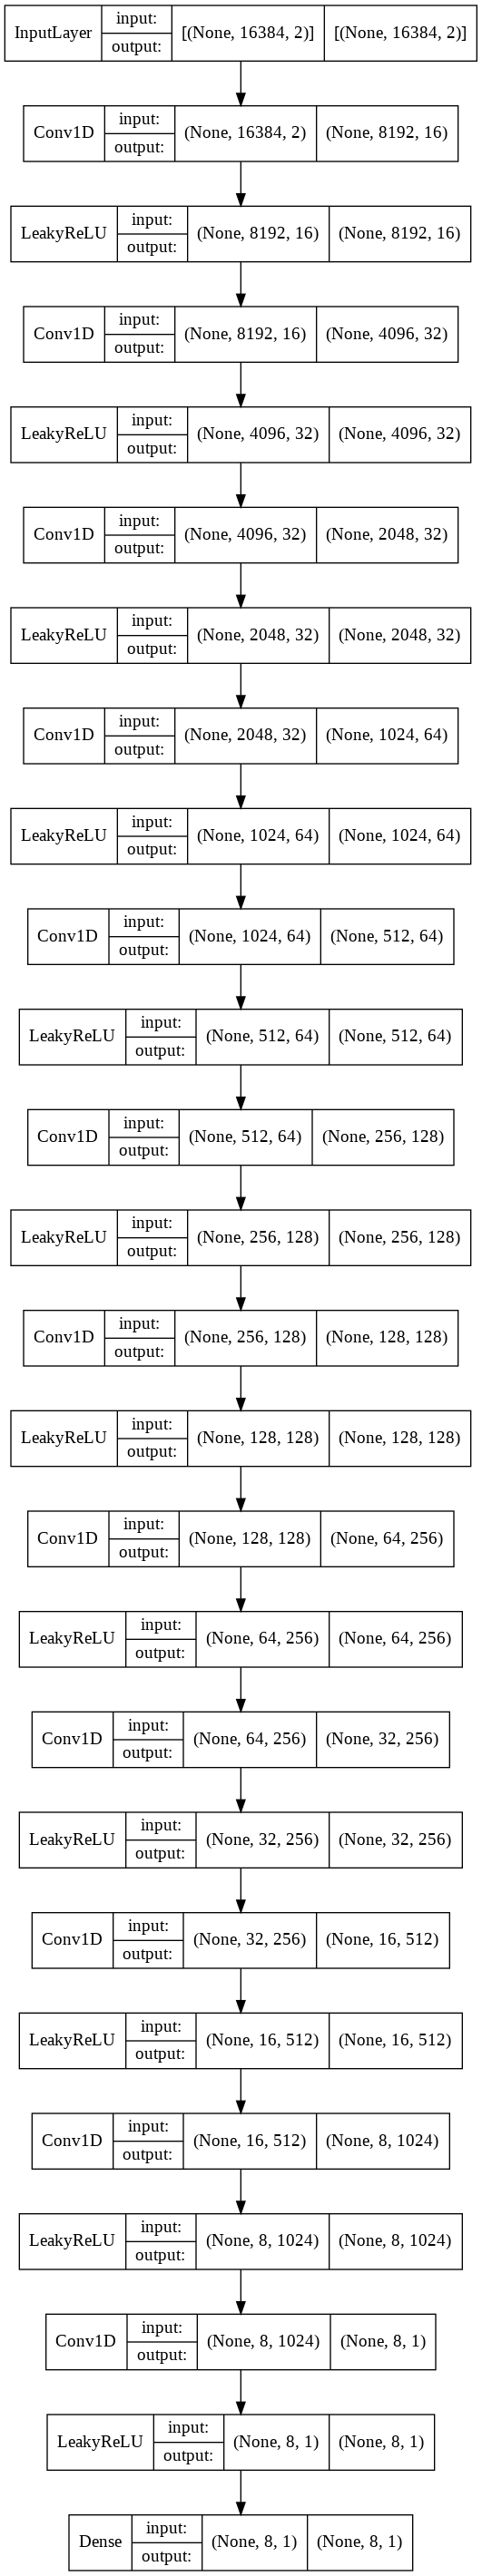

In [ ]:
tf.keras.utils.plot_model(discriminatormodel,show_shapes=True,show_layer_names=False)

### Compiling the Discriminator model

In [ ]:
discriminatormodel.compile(loss = 'binary_crossentropy', optimizer = 'adam')

### Training the Discriminator model initially on some amount of data

In [ ]:
## training the discriminator model initially


### A function to train the discriminator model

In [ ]:
## function that trains the discriminator model

## Defining the GAN model
- We make a function that returns the combined GAN model
- We make it by combining the previously built discriminator and generator model sequentially
- We make the *parameters of discriminator* model *non-trainable*
- We will train the discriminator model's parameters seperately via a manually written $for$ loop 

In [ ]:
# function that returns the GAN model by combining the generator and discriminator models given as input
def gan_model(g_model, d_model):
  d_model.trainable = False
  model = Sequential([
          g_model,
          d_model,                   
  ])
  return model

## Training the GAN model
- A function that trains the GAN model
- It will train the GAN model by training the discriminator and then it will train the generator based on the results of the discriminator's classification